In [1]:
#import the neccesary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import re
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import skimage.transform

def CreateSet(input_list,N_patches,patchsize):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchszize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 2), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,400-patchsize)
            yloc = random.randint(0,800-patchsize)
            #input 
            img_input1 = Image.open('bandLimited_model1/input_%03d.png' % (i+1))
            in_img_input1 = tf.keras.preprocessing.image.img_to_array(img_input1)
            in_img_input1 = in_img_input1[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input1 = skimage.transform.resize(in_img_input1 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            img_input2 = Image.open('bandLimited_model2/input_%03d.png' % (i+1))
            in_img_input2 = tf.keras.preprocessing.image.img_to_array(img_input2)
            in_img_input2 = in_img_input2[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input2 = skimage.transform.resize(in_img_input2 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X1 = in_img_input1 / 255.0
            X2 = in_img_input2 / 255.0
            X[ii] = np.concatenate((X1,X2),axis=-1)
            #output
            img_output = Image.open('groundTruth/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            y[ii] = in_img_output / 255.0
            if ii % 1000 == 0:
                print(ii)
    print('Done')
    return X,y
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
#Train set is image 1 till 401
X_train,y_train = CreateSet(range(401),N_patches,patchsize)
#validation set is image 401 till 535
X_valid,y_valid = CreateSet(range(401,535),N_patches,patchsize)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Done
0
1000
2000
3000
4000
5000
6000
7000
8000
Done


In [3]:
#Create the arrays for the Test set which are the image 601 till 669
test_set_indices = range(535,669)

Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
for i,n in enumerate(test_set_indices):
    img = Image.open('bandLimited/input_%03d.png' % (n+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_X[i] =in_img_input / 255.0

    img = Image.open('groundTruth/target_%03d.png' % (n+1))
    in_img_output = tf.keras.preprocessing.image.img_to_array(img)
    in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_y[i] =in_img_output / 255.0

In [2]:
def Conv2D_Block(input_tensor , n_filters):
    """
    A function that defines a block of two conv2D layers
    Parameter: input_tensor: the model/input tensor to which these layers are added
    returns: x: the model with the two conv2D layer
    """
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def U_Net(img_tensor , n_filters = 16):
    """
    Creates the U_net model
    returns: u_net, the u_net model
    """
    #512X512
    conv1 = Conv2D_Block(img_tensor , n_filters * 1)
    pool1 = tf.keras.layers.MaxPooling2D((2 , 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.05)(pool1)
    #256x256
    conv2 = Conv2D_Block(pool1 , n_filters * 2)
    pool2 = tf.keras.layers.MaxPooling2D((2 , 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.05)(pool2)
    #128x128
    conv3 = Conv2D_Block(pool2 , n_filters * 4)
    pool3 = tf.keras.layers.MaxPooling2D((2 , 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.05)(pool3)
    #64x64
    conv4 = Conv2D_Block(pool3 , n_filters * 8)
    pool4 = tf.keras.layers.MaxPooling2D((2 , 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.05)(pool4)
    #32x32
    conv5 = Conv2D_Block(pool4 , n_filters * 16)
    #32x32
    pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8 , (3 , 3) , (2, 2) , padding = 'same')(conv5)
    pool6 = tf.keras.layers.concatenate([pool6 , conv4])
    pool6 = tf.keras.layers.Dropout(0.05)(pool6)
    conv6 = Conv2D_Block(pool6 , n_filters * 8)
    #64x64
    pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4 , (3 , 3) , (2 , 2) , padding = 'same')(conv6)
    pool7 = tf.keras.layers.concatenate([pool7 , conv3])
    pool7 = tf.keras.layers.Dropout(0.05)(pool7)
    conv7 = Conv2D_Block(pool7 , n_filters * 4)
    #128x128
    pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2 , (3 , 3) , (2 , 2) , padding = 'same')(conv7)
    pool8 = tf.keras.layers.concatenate([pool8 , conv2])
    pool8 = tf.keras.layers.Dropout(0.05)(pool8)
    conv8 = Conv2D_Block(pool8 , n_filters * 2)
    #256x256
    pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1 , (3 , 3) , (2 , 2) , padding = 'same')(conv8)
    pool9 = tf.keras.layers.concatenate([pool9 , conv1])
    pool9 = tf.keras.layers.Dropout(0.05)(pool9)
    conv9 = Conv2D_Block(pool9 , n_filters * 1)
    #512x512
    #use relu for the activation
    output = tf.keras.layers.Conv2D(1 , (3 , 3), padding = 'same')(conv9)

    u_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])

    return u_net

In [4]:
#define and compile the model
img_tensor = tf.keras.layers.Input((None , None , 2) , name = 'img')
model = U_Net(img_tensor,16)

In [5]:

model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
            loss=tf.keras.losses.meansquarederror(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [8]:
model.summary()

In [6]:
model_path = 'model_unetDoubleInput_Ultrasound_data.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
#train the model
results = model.fit(X_train,y_train, epochs=100, callbacks=callbacks,batch_size = 16,
                    validation_data=(X_valid,y_valid),shuffle=False)

Epoch 1/100
1602/1604 [============================>.] - ETA: 0s - loss: 0.0304 - root_mean_squared_error: 0.1743
Epoch 00001: val_loss improved from inf to 0.01025, saving model to model_unetDoubleInput_Ultrasound_data.h5
1604/1604 [==============================] - 47s 29ms/step - loss: 0.0304 - root_mean_squared_error: 0.1743 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013 - lr: 1.0000e-04
Epoch 2/100
1603/1604 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1085
Epoch 00002: val_loss improved from 0.01025 to 0.00978, saving model to model_unetDoubleInput_Ultrasound_data.h5
1604/1604 [==============================] - 47s 29ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989 - lr: 1.0000e-04
Epoch 3/100
1602/1604 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1028- ETA: 1s - loss: 0.0106 - root_mean_sq
Epoch 00003: val_loss did not imp

In [8]:
#load the model
model.load_weights(model_path)

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


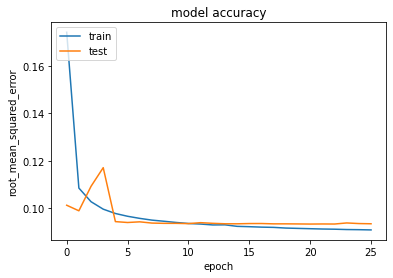

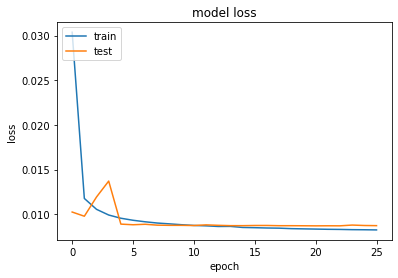

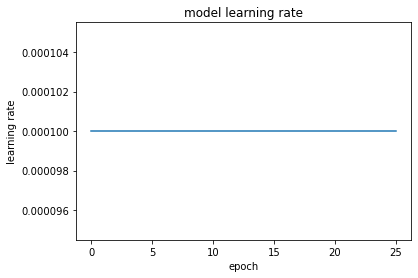

In [12]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(results.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

In [14]:
#Visualise the bandwidth limited, model predicted and target image
n =5
prediction = model.predict(np.expand_dims(Test_set_X[n,:800,:400],0))

prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
ax[1].imshow(Test_set_X[n,:800,:400].squeeze()+prediction_image,cmap='gray')
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

ValueError: in user code:

    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/laslo-bep/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 800, 400, 1]


In [10]:
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    """
    Function that reads in the test set images as arrays and scales them between 0 and 1
    parameters:test_set_indices: The indices of the the images in the test set
                 input_dir_test: The directory where the input png images are stored
                output_dir_test: The directory where the output png images are stored
    returns: Test_set_X: an array of input images
             Test_set_y: an array of output images
    """
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
#run for all the test sets
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    #Create the input and output arrays for the test set
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)    
    val_set_model1 = np.load('Model_output_test_'+dataset+'unetmodel1_ultrasound.npy')
    val_set_model2 = np.load('Model_output_test_'+dataset+'unetmodel2_ultrasound.npy')
    MODEL1 = np.zeros([len(val_set_model1),800,400,1])
    MODEL2 = np.zeros([len(val_set_model1),800,400,1])
    for i in range(len(val_set_model1)):
        img1 = skimage.transform.resize(val_set_model1[i] , (800 , 400 , 1) , mode = 'constant' , preserve_range = True)
        img2 = skimage.transform.resize(val_set_model2[i] , (800, 400 , 1) , mode = 'constant' , preserve_range = True)
        MODEL1[i] = img1
        MODEL2[i] = img2
    val_set_model1and2 = np.concatenate((MODEL1,MODEL2),axis=-1)
    prediction_images = np.zeros_like(val_set_model1)
    for i in range(len(val_set_model1)):
        predicted_array = model.predict(np.expand_dims(val_set_model1and2[i],0))
        prediction_IMAGE = predicted_array.squeeze()
        prediction_images[i] = prediction_IMAGE
    np.save('Model_output_test_'+dataset+'unetmodel4_ultrasound.npy',prediction_images)

Done
Done
Done
